## Computer Vision Libraries in PyTorch

* `torchvision`: base vision library for PyTorch computer vision
* `torchvision.datasets`: Get datasets and data loading functions
* `torchvision.models`: Get pre-trained computer vision models
* `torchvision.transforms`: Functions for manipulating your vision data to be suitable for use with an ML model.
* `torch.utils.data.Dataset`: Base dataset class for PyTorch
* `torch.utils.data.DataLoader`: Python iterable over a dataset 

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check version
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu118
0.21.0+cu118


## 1. Getting dataset

FashionMNIST which is take on MNIST database from torchvision.datasets

In [2]:
train_data = datasets.FashionMNIST(
    root = 'data/', 
    train=True, # Download training dataset if true, else testing datasets 
    download= True,
    transform= ToTensor(),
    target_transform= None
)
test_data = datasets.FashionMNIST(
    root = 'data/',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform= None
)


In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See first training example
image, label = train_data[0]

In [6]:
label

9

In [7]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
# Check shape of image
image.shape

torch.Size([1, 28, 28])

## 1.2 Visualizing data

Text(0.5, 1.0, '9')

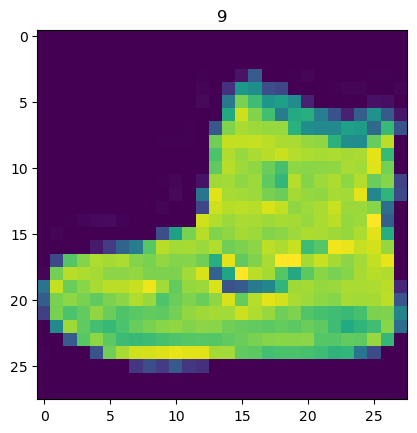

In [10]:
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

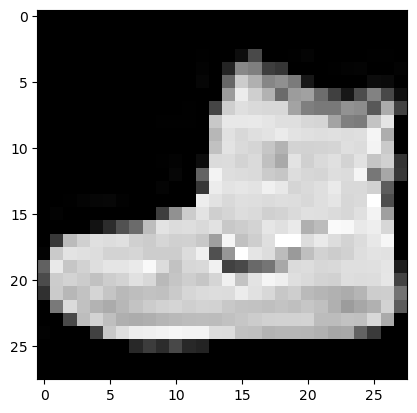

In [11]:
plt.imshow(image.squeeze(), cmap = 'grey')

In [12]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

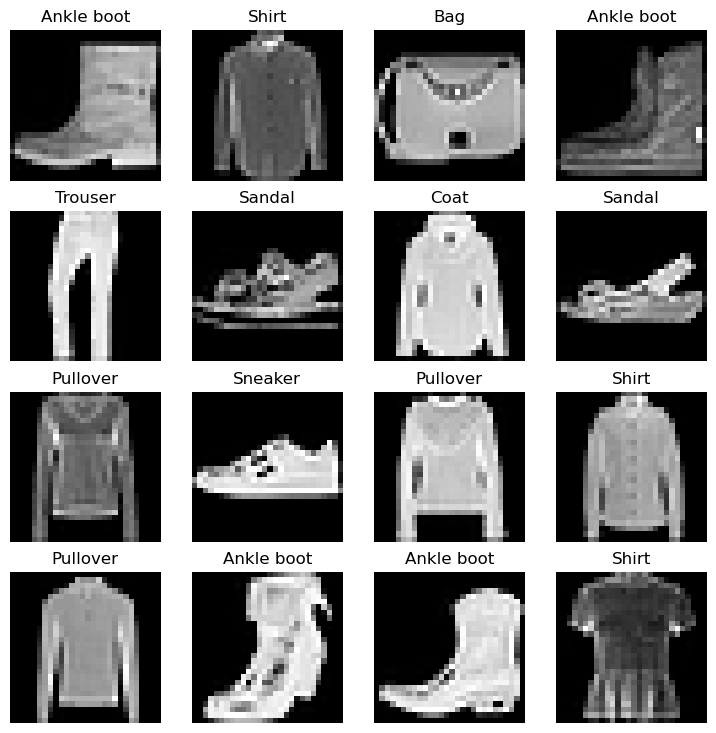

In [13]:
# plot more image
torch.manual_seed(42)
fig = plt.figure(figsize= (9,9))
rows, cols = 4,4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'grey')
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare dataloader

Right now our data is in the form of PyTorch datasets.

Dataloader turns our dataset into a python iterable.

More specifically, we want to turn our data into batches or mini batches.

Why?

1. It is more computationally efficient, as in we cant store 60000 images in one go, so we break it down into 32 images per batch.

2. It gives our neural networks more chances to update its gradient per epoch

In [14]:
# Setup batch size 
BATCH_SIZE = 32
# turn datasets into iterables
train_dataloader = DataLoader(
    dataset= train_data,
    batch_size=BATCH_SIZE,
    shuffle= True
)
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle= False
)

In [15]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2077165eb00>,
 <torch.utils.data.dataloader.DataLoader at 0x2077167ae00>)

In [16]:
# Check out what's inside training dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [17]:
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

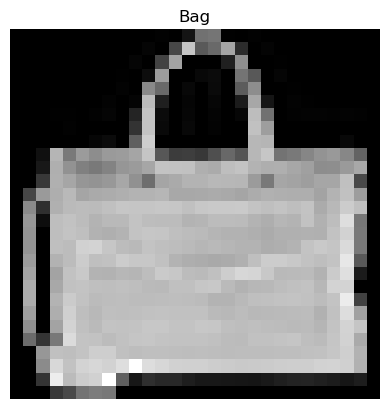

In [18]:
# Show sample 

# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'grey')
plt.title(class_names[label])
plt.axis(False);


## 3. Build Baseline Model

When starting to build a series of machine learning model its best practice to build a baseline model.

A baseline model is a simple model that we will try to improve upon with subsequent models.

In other words start simply and add complexity when neccessary.

In [19]:
# Create a flatten layer

flatten_model = nn.Flatten()

# Get a sinlge sample 
x = train_features_batch[0]
x.shape

torch.Size([1, 28, 28])

In [20]:
flatten_model(x).shape # Perform forward pass

torch.Size([1, 784])

In [21]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features= output_shape)
        )
    def forward(self, x):
        return self.layers(x)

In [22]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape= 28 * 28,
    hidden_units= 10, # How many units in hidden layer
    output_shape= len(class_names)
).to("cpu")
model_0

FashionMNISTModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [23]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [24]:
model_0.state_dict()

OrderedDict([('layers.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layers.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layers.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.3130, -0.0118,


### 3.1 Setup loss function, optimizer and evaluation metrics:

* Loss Function: Since we're working with multiclass data our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - Our optimizer will be `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metrics: Since we're working with classification we will use Accuracy.

In [25]:
# Download helper functions from git repo

import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("Script already exists")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        

Script already exists


In [26]:
from helper_functions import accuracy_fn

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params = model_0.parameters(),
    lr = 0.1
)

### 3.2 Creating function to time our experiments:

Two things we want to track are:
* Our model's performance (loss and accuracy values)
* How fast it runs

In [27]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [28]:
start_time = timer()
## SOme code
end_time = timer()
print_train_time(start_time, end_time, "CPU")

Train time on CPU: 0.000 seconds


2.25000039790757e-05

## 3.3 Creating a training loop and training a model on batches of data:

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate training loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening
5. Time it.

In [30]:
# Import tqdm for progress bar 
from tqdm.auto import tqdm

# Set the seed and start timer
torch.manual_seed(42)
train_time_start_cpu= timer()

# Set number of epochs
EPOCHS = 3

# Create training and test loop

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch} \n----")
    # Training 
    train_loss = 0
    # Add a loop to through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Foward pass
        y_pred = model_0(X)
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss+= loss # accumulate train loss
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
        # Print
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing 
    test_loss, test_accuracy = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Forward pass
            test_pred = model_0(X_test)
            # Caluclate loss
            test_loss += loss_fn(test_pred, y_test)
            # Calculate accuracy
            test_accuracy += accuracy_fn(y_true= y_test, y_pred = test_pred.argmax(dim = 1))
        # Calculate test loss average per batch
        test_loss /= len(test_dataloader)
        # Calculate test accuracy per batch
        test_accuracy /= len(test_dataloader)
    print(f"\n Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} |  Test Accuracy: {test_accuracy:.4f}")
train_time_end_cpu = timer()
total_train_time_model_0 = print_train_time(
    start = train_time_start_cpu,
    end = train_time_end_cpu,
    device=str(next(model_0.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

 Train Loss: 0.5904 | Test Loss: 0.5095 |  Test Accuracy: 82.0387
Epoch 1 
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

 Train Loss: 0.4763 | Test Loss: 0.4799 |  Test Accuracy: 83.1969
Epoch 2 
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

 Train Loss: 0.4550 | Test Loss: 0.4766 |  Test Accuracy: 83.4265
Train time on cpu: 26.596 seconds


## 4. Make predictions and get model 0 results



In [46]:
torch.manual_seed(42)
def evaluate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.dataloader,
                   loss_fn: torch.nn.Module,
                   accuracy_fn, 
                   device: torch.device = device):
    """Return a dictonary of containing results of model predicting on dataloader."""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            # Make preds
            y_pred = model(X)
            # Accumulate loss and accuracy per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true = y, y_pred= y_pred.argmax(dim = 1))
        # Scale loss and accuracy to find average loss and accuray per batch
        loss /= len(dataloader)
        acc /= len(dataloader)
    return {
        "Model Name": model.__class__.__name__, # Only works when model is created with class
        "Model Loss": loss.item(),
        "Model accuracy": acc
    }

## 5. Setup device agnostic code

In [43]:
# Calculate model 0 results on test dataset
model_0_results = evaluate_model(model_0, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [44]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [45]:
model_0_results

{'Model Name': 'FashionMNISTModelV0',
 'Model Loss': 0.47663894295692444,
 'Model accuracy': 83.42651757188499}

## 6. Model 1: Building a better model with non-linearity

In [47]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units,out_features = output_shape),
        )
    def forward(self, x):
        return self.layers(x)
        

In [48]:
model_1 = FashionMNISTModelV1(
    input_shape= 28 * 28,
    hidden_units = 32,
    output_shape=len(class_names)
).to(device)

In [49]:
model_1.state_dict()

OrderedDict([('layers.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0023,  0.0071,  0.0330,  ...,  0.0164, -0.0095, -0.0053],
                      [ 0.0167, -0.0324,  0.0086,  ..., -0.0090,  0.0203, -0.0100],
                      [-0.0118,  0.0119, -0.0080,  ..., -0.0193,  0.0170,  0.0246]],
                     device='cuda:0')),
             ('layers.1.bias',
              tensor([ 0.0161, -0.0159,  0.0234,  0.0084, -0.0339, -0.0047, -0.0323, -0.0125,
                       0.0065, -0.0339, -0.0036,  0.0208,  0.0018,  0.0308, -0.0056, -0.0006,
                      -0.0294, -0.0100,  0.0059,  0.0271,  0.0328, -0.0049,  0.0312,  0.0041,
                       0.0242,  0.0212, -0.0234,  0.0345,  0.0085, -0.0198, -0.034

In [50]:
optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.01)

In [51]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.dataloader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training loop with model to learn on dataloaders"""
    # Set the seed and start timer
    torch.manual_seed(42)
    # Set number of epochs
    EPOCHS = epochs
    # Training 
    train_loss, train_acc = 0, 0
    # Add a loop to through the training batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        model.train()
        # 1. Foward pass
        y_pred = model(X)
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss+= loss.item() # accumulate train loss
        train_acc+= accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"\n Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

In [52]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    "Performs a testing loop step on model going over data loader"
    ### Testing 
    test_loss, test_accuracy = 0,0
    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in dataloader:
            # Forward pass
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            test_pred = model(X_test)
            # Caluclate loss
            test_loss += loss_fn(test_pred, y_test).item()
            # Calculate accuracy
            test_accuracy += accuracy_fn(y_true= y_test, y_pred = test_pred.argmax(dim = 1))
        # Calculate test loss average per batch
        test_loss /= len(dataloader)
        # Calculate test accuracy per batch
        test_accuracy /= len(dataloader)
    print(f"Test Loss: {test_loss:.4f} |  Test Accuracy: {test_accuracy:.2f}%")

In [53]:
from helper_functions import accuracy_fn

epochs = 3
torch.manual_seed(42)
train_time_start_gpu= timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}---\n")
    train_step(
        model= model_1,
        dataloader=train_dataloader,
        optimizer = optimizer, 
        loss_fn=loss_fn, 
        accuracy_fn=accuracy_fn, 
        device=device)
    test_step(model= model_1,
        dataloader=test_dataloader,
        loss_fn=loss_fn, 
        accuracy_fn=accuracy_fn, 
        device=device)
train_time_end_gpu = timer()
total_train_time_model_1 = print_train_time(
    start = train_time_start_gpu,
    end = train_time_end_gpu,
    device=str(next(model_1.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0---


 Train Loss: 0.9503 | Train Accuracy: 68.23%
Test Loss: 0.6549 |  Test Accuracy: 77.27%
Epoch: 1---


 Train Loss: 0.5794 | Train Accuracy: 80.11%
Test Loss: 0.5548 |  Test Accuracy: 81.05%
Epoch: 2---


 Train Loss: 0.5128 | Train Accuracy: 82.42%
Test Loss: 0.5148 |  Test Accuracy: 82.10%
Train time on cuda:0: 35.054 seconds


In [54]:
torch.cuda.empty_cache()

In [55]:
model_0_results

{'Model Name': 'FashionMNISTModelV0',
 'Model Loss': 0.47663894295692444,
 'Model accuracy': 83.42651757188499}

## Note:

Sometimes depending on data and hardware we might find that model trains faster on GPU than CPU

Why is this? 

* It could be that the overhead for copying data/model to and from the GPU outweighs the compute benifits offered by the GPU.
* The hardware you're using has a better CPU in terms compute capability than the GPU.

https://horace.io/brrr_intro

In [56]:
# Get model 1 results dictionary
model_1_results = evaluate_model(model_1, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [57]:
model_1_results

{'Model Name': 'FashionMNISTModelV1',
 'Model Loss': 0.514808714389801,
 'Model accuracy': 82.09864217252397}

## Model 2: Building a Convolutional Neural Network:

CNN's are also known as ConvNets.

CNN's are also known for their capabilities to find patterns in visual data

In [58]:
# Create a Conv network

class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG from CNN Explainer.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels= hidden_units,
                      kernel_size = (3,3),
                      stride = 1,
                      padding = 1,
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3,3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels= hidden_units,
                kernel_size = (3,3),
                stride = 1, 
                padding = 1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels= hidden_units,
                kernel_size = (3,3),
                stride = 1, 
                padding = 1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 7*7,
                     out_features = output_shape,
                     )
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        return self.classifier(x)

In [59]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape= 1, hidden_units= 10, output_shape=len(class_names)).to(device)

In [60]:
# Create random tensor
rand_image_tensor = torch.randn(size = (1, 28,28)).to(device)
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [61]:
# Pass image through model
model_2(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [62]:
image.shape

torch.Size([1, 28, 28])

## 7.1 Stepping though `nn.Conv2d()`:

In [63]:
torch.manual_seed(42)
image = torch.randn(32, 3, 64, 64)
test_image = image[0]
print(f"Image Batch size: {image.shape} | Single image shape: {test_image.shape}")

Image Batch size: torch.Size([32, 3, 64, 64]) | Single image shape: torch.Size([3, 64, 64])


In [64]:
# Create a single Conv2d Layer
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3, out_channels= 10, kernel_size=(3,3), stride = 1, padding = 1)

# Pass the data through the Conv layer
conv_output = conv_layer(test_image)

In [65]:
test_image.shape

torch.Size([3, 64, 64])

In [66]:
conv_output.shape

torch.Size([10, 64, 64])

## 7.2 Stepping thorugh `nn.MaxPool2d()`

In [67]:
max_pool_layer = nn.MaxPool2d(kernel_size= (2,2))
# Pass data through Conv2d Layer
print(f"Test image shape: {test_image.shape}")
conv_layer = nn.Conv2d(in_channels=3, out_channels= 10, kernel_size=(3,3), stride = 1, padding = 1)
# Pass the data through the Conv layer
conv_output = conv_layer(test_image)
print(f"Shape after conv2d: {conv_output.shape}")
test_image_thorugh_conv_and_max = max_pool_layer(conv_output)
print(f"Shape after going through ConvLayer and MaxPool layer: {test_image_thorugh_conv_and_max.shape}")

Test image shape: torch.Size([3, 64, 64])
Shape after conv2d: torch.Size([10, 64, 64])
Shape after going through ConvLayer and MaxPool layer: torch.Size([10, 32, 32])


## 7.2 Setup loss function and optimizer

In [68]:
# Setup loss function/evaluation metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr = 0.1)

## 7.4 Training our model using `train_step()` and `test_step()`

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure Time
from timeit import default_timer as timer

train_time_start_model_2 = timer()
# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-----")
    train_step(
        model = model_2,
        dataloader=train_dataloader,
        optimizer= optimizer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(
        model= model_2,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end= train_time_end_model_2, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-----

 Train Loss: 0.5934 | Train Accuracy: 78.50%
Test Loss: 0.3974 |  Test Accuracy: 85.65%
Epoch 1
-----

 Train Loss: 0.3608 | Train Accuracy: 87.01%
Test Loss: 0.3450 |  Test Accuracy: 87.43%
Epoch 2
-----

 Train Loss: 0.3231 | Train Accuracy: 88.27%
Test Loss: 0.3316 |  Test Accuracy: 88.06%
Train time on cuda: 41.456 seconds


In [70]:
model_2_results = evaluate_model(
    model = model_2,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device = device
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [71]:
model_2_results

{'Model Name': 'FashionMNISTModelV2',
 'Model Loss': 0.33160749077796936,
 'Model accuracy': 88.0591054313099}

In [72]:
model_0_results

{'Model Name': 'FashionMNISTModelV0',
 'Model Loss': 0.47663894295692444,
 'Model accuracy': 83.42651757188499}

In [73]:
model_1_results

{'Model Name': 'FashionMNISTModelV1',
 'Model Loss': 0.514808714389801,
 'Model accuracy': 82.09864217252397}

# 8. Compare model results and training time

In [74]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,Model Name,Model Loss,Model accuracy
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.514809,82.098642
2,FashionMNISTModelV2,0.331607,88.059105


In [76]:
# Add training time to resutls comparision

compare_results['train_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,Model Name,Model Loss,Model accuracy,train_time
0,FashionMNISTModelV0,0.476639,83.426518,26.596393
1,FashionMNISTModelV1,0.514809,82.098642,35.053675
2,FashionMNISTModelV2,0.331607,88.059105,41.455980


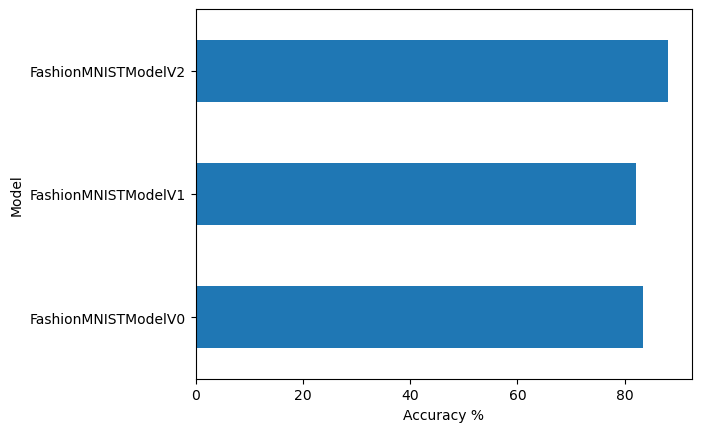

In [80]:
# Visualize our model's results

compare_results.set_index("Model Name")['Model accuracy'].plot(kind = 'barh')
plt.xlabel("Accuracy %")
plt.ylabel("Model");

## 9. Make and evaluate random predictions with best model

In [95]:
def make_preds(model: torch.nn.Module,
              data: list,
              device: torch.device= device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            # Forward pass
            pred_logits = model(sample)
            # Get Preds Probability
            pred_prob = torch.softmax(pred_logits.squeeze(), dim = 0)
            # Get pred_probs off GPU  for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred probs to turn list into tensors
    return torch.stack(pred_probs)

In [96]:
import numpy as np

In [110]:
import random 
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

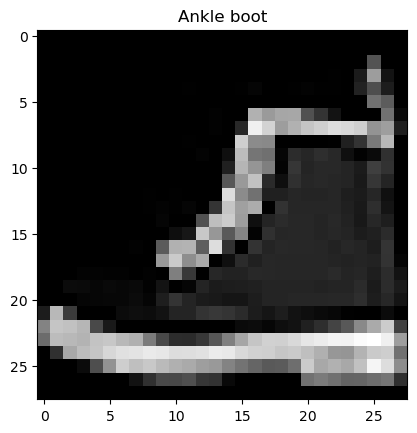

In [111]:
plt.imshow(test_samples[0].squeeze(), cmap = 'grey')
plt.title(class_names[test_labels[0]]);

In [112]:
# Make Predictions
pred_probs = make_preds(
    model= model_2,
    data= test_samples
)
# View First two preds
pred_probs[:2]

tensor([[1.6760e-05, 1.3499e-05, 4.2298e-05, 5.3607e-05, 1.4057e-04, 1.0569e-02,
         5.2313e-06, 5.9401e-03, 3.3438e-02, 9.4978e-01],
        [1.9804e-04, 4.3872e-06, 2.1822e-04, 1.2086e-05, 2.2681e-05, 2.1143e-03,
         4.1589e-06, 8.9507e-01, 3.1433e-03, 9.9209e-02]])

In [113]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([9, 7, 2, 0, 1, 0, 3, 5, 4])

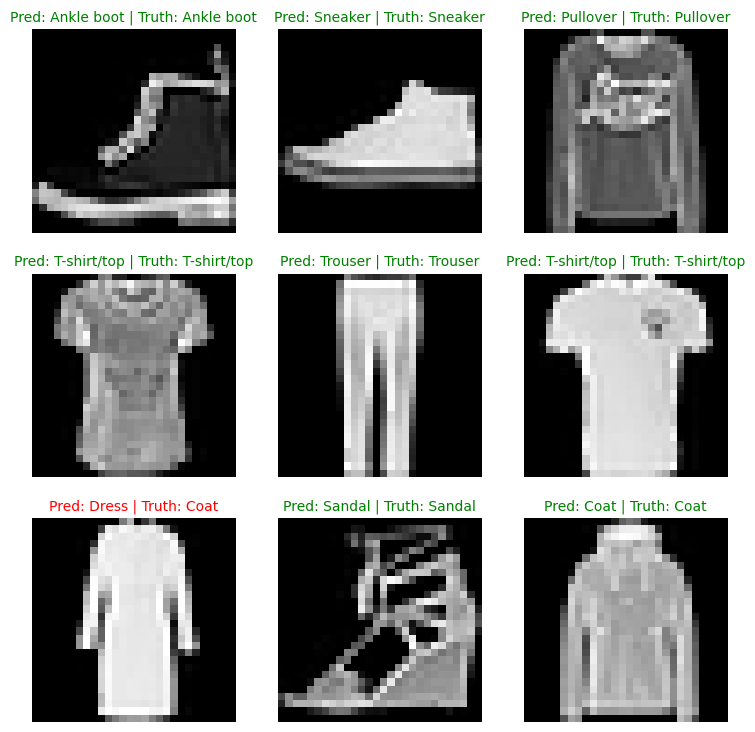

In [114]:
# Plot predictions 
plt.figure(figsize = (9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap = 'grey')
    # FInd predicitions in test form
    pred_label = class_names[pred_classes[i]]
    # Get truth label
    truth_label = class_names[test_labels[i]]
    title = f"Pred: {pred_label} | Truth: {truth_label}"
    # Check for equality between pred and truth and change color of text
    if pred_label == truth_label:
        plt.title(title, fontsize = 10, c ='g')
    else:
        plt.title(title, fontsize = 10, c ='r')
    plt.axis('off')

## 10. Make a confusion matrix